## Ecommerce Trade Sales

In [1]:
# Import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pytrends.request import TrendReq
from statsmodels.tsa.stattools import kpss, adfuller
import statsmodels.api as sm

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from statsmodels.graphics.tsaplots import *
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose

from scipy.stats import pearsonr
from sklearn.linear_model import Lasso
from sklearn.preprocessing import scale

import xgboost as xgb
from xgboost import XGBRegressor
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error

from sklearn.ensemble import RandomForestRegressor

import warnings
warnings.filterwarnings("ignore")

In [2]:
data = pd.read_csv('../../data/retailEcommercesales/retailEcommerceSales.csv',sep=',')
data.head(2)

,REF_DATE,GEO,DGUID,Sales,UOM,UOM_ID,SCALAR_FACTOR,SCALAR_ID,VECTOR,COORDINATE,VALUE,STATUS,SYMBOL,TERMINATED,DECIMALS
0,2016-01,Canada,2016A000011124,"Retail trade, unadjusted\n [44-453]",Dollars,81,thousands,3,v108795018,1.1,37415147,A,NaN,NaN,0
1,2016-01,Canada,2016A000011124,"Electronic shopping and mail-order houses, una...",Dollars,81,thousands,3,v108795019,1.2,679612,B,NaN,NaN,0


In [3]:
# data filter
retailEcommercesales = data[~data["Sales"].str.contains('unadjusted')]
retailEcommercesales = retailEcommercesales.filter(['REF_DATE','VALUE'])
retailEcommercesales = retailEcommercesales.set_index('Date')
retailEcommercesales.index = pd.to_datetime(retailEcommercesales.index)
# rename columns
retailEcommercesales = retailEcommercesales.rename(columns = {'REF_DATE': 'Date', 'VALUE': 'Ecommerce_sales'})

In [4]:
retailEcommercesales.head(2)

,Date,Ecommerce_sales
3,2016-01,977198
7,2016-02,1006610


**Time series plot of Ecommerce trade sales**

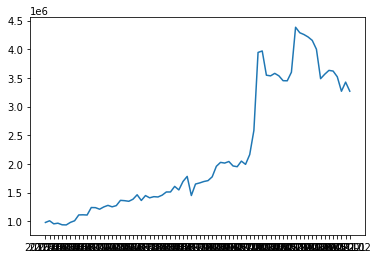

In [5]:
retailEcommercesales_dup = retailEcommercesales.copy()
retailEcommercesales_dup.index = retailEcommercesales_dup['Date']
plt.plot(retailEcommercesales_dup['Ecommerce_sales'])
plt.show()

In [6]:
retailEcommercesales_ts = retailEcommercesales.set_index('Date')

In [7]:
retailEcommercesales_ts.head(2)

,Ecommerce_sales
Date,
2016-01,977198
2016-02,1006610


In [8]:
retailEcommercesales_ts['Growth_rate'] = retailEcommercesales_ts.pct_change()
retailEcommercesales_ts = retailEcommercesales_ts.dropna() # removing NA
retailEcommercesales_ts.index = pd.to_datetime(retailEcommercesales_ts[['Growth_rate']].index)
#plt.plot(retailEcommercesales_ts['Growth_rate'])
#plt.show()

In [9]:
retailEcommercesales_ts.head(2)

,Ecommerce_sales,Growth_rate
Date,,
2016-02-01,1006610,0.030098
2016-03-01,953186,-0.053073


In [163]:
def plot_df(y, title="", xlabel='Date', ylabel='Value', dpi=100, width = 16, height = 5):
    plt.figure(figsize=(width,height), dpi=dpi)
    plt.plot(y)
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.close()

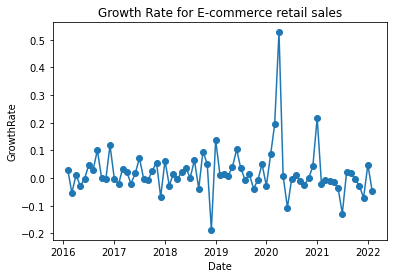

<Figure size 1600x500 with 0 Axes>

In [11]:
# Plot

plt.plot(retailEcommercesales_ts['Growth_rate'], marker = 'o')

# Labelling
plt.xlabel("Date")
plt.ylabel("GrowthRate")
plt.title("Growth Rate for E-commerce retail sales")
plt.figure(figsize = (16,5), dpi = 100)

# Display
plt.show()

### Stationarity Statistical test

**KPSS and ADF Test**

In [12]:
def adf_test(timeseries):
    #print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    #print(dfoutput)
    if dftest[1] < 0.05:
        return f"Series is stationary"
    else:
        return f"Series is not stationary"


def kpss_test(timeseries):
    #print("Results of KPSS Test:")
    kpsstest = kpss(timeseries, regression="c", nlags="auto")
    kpss_output = pd.Series(
        kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"]
    )
    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)" % key] = value
    #print(kpss_output)
    if kpsstest[1] > 0.05:
        return f"Series is stationary"
    else:
        return f"Series is not stationary"
        
def check_stationarity(dataframe):
    for i in range(0,dataframe.shape[1]):
        timeseries = dataframe.iloc[:,i]
        adf_result = adf_test(timeseries)
        kpss_result = kpss_test(timeseries)
        if (adf_result == "Series is stationary") and (kpss_result == "Series is stationary"):
            pass
        elif (adf_result == "Series is not stationary") and (kpss_result == "Series is not stationary"):
            print(f"Series {dataframe.columns[i]} is not stationary")
        elif (adf_result == "Series is stationary") and (kpss_result == "Series is not stationary"):
            print(f"Series {dataframe.columns[i]} is not stationary, differencing can be used to make it stationary")
        elif (adf_result == "Series is not stationary") and (kpss_result == "Series is stationary"):
            print(f"Series {dataframe.columns[i]} is trend stationary, trend needs to be removed")
    print("All other series are stationary")

**Testing the ecommerce sale\'s series stationarity**

In [13]:
kpss_test(retailEcommercesales_ts['Growth_rate'])
adf_test(retailEcommercesales_ts['Growth_rate'])

'Series is stationary'

## Keywords extraction using PyTrend

In [14]:
pytrends = TrendReq(hl = 'en-us', backoff_factor = 0.1)

def ecommerce_trend(keywords = [''],category = '340'):  #subcat - 280
    
    """ 
    Function for getting trends for selected keywords
        
        arguments: 
        
            Keywords: List of String ser
            category: String: stores the code for category
        
        returns: Related queries and related topics from google trend as a data frame
    """
    kw_list = keywords
    cat = category
    timeframe = '2004-01-01 2022-05-11'
    geo = 'CA'
    
    pytrends.build_payload(kw_list, cat, timeframe, geo, gprop = '')
    data = pytrends.interest_over_time()
    queries = pytrends.related_queries()
    topics = pytrends.related_topics()
    
    return data, queries, topics

In [15]:
data2, queries2, topics2 = ecommerce_trend(keywords = ['Doordash'],category = '340')

In [16]:
data2.tail()

,Doordash,isPartial
date,,
2022-01-01,100,False
2022-02-01,91,False
2022-03-01,58,False
2022-04-01,82,False
2022-05-01,64,False


**Extracting time series from manually extracted keywords**

In [68]:
keywordsDictQuery = dict() #Dictionary for queries
keywordsDictTopic = dict() #Dictionary for topic

keywords_csv = pd.read_csv('../../data/keywords_data/EECOMMERCE.csv')

In [18]:
for index, row in keywords_csv.iterrows():
    data, queries, topics=ecommerce_trend(keywords=[str(row['Keyword'])],category=str(row['SubcatNo']))
    
    if index==0:
        FinalData, queries, topics=ecommerce_trend(keywords=[str(row['Keyword'])],category=str(row['SubcatNo']))
        FinalData.rename(columns = {'':str(row['Keyword'])}, inplace = True)    #column name for frame
        FinalData=FinalData.drop(columns=['isPartial'])   #remove column
    else:
        data, queries, topics=ecommerce_trend(keywords=[str(row['Keyword'])],category=str(row['SubcatNo']))
        data.rename(columns = {'':str(row['Keyword'])}, inplace = True)
        data=data.drop(columns=['isPartial'])
        data = data[str(row['Keyword'])]
        FinalData = FinalData.join(data)

In [ ]:
#keywords exported as CSV with revelant time series
FinalData.to_csv('EEcommerceKeywordTimeSeries.csv')

**Extracting Queries and related topics time series**

In [20]:
category_ts, queries, topics = ecommerce_trend(keywords = [''],category = '340')  #function calling

keyword_query_frame = dict()  #Dictionary for queries
keyword_topic_frame = dict()  #Dictionary for topic

# keywords from queries
keyword_rising_query = queries['']['rising']['query'].unique().tolist() 
keyword_top_query = queries['']['top']['query'].unique().tolist()

# keywords from topic
keyword_rising_topics = topics['']['rising']['topic_title'].unique().tolist() 
keyword_top_topics = topics['']['top']['topic_title'].unique().tolist()

In [21]:
# keywords dict
keyword_query_frame['340'] = keyword_top_query
keyword_topic_frame['340'] = keyword_top_topics

In [22]:
# keywords from google trend query and topics
keyword_topic_frame

{'340': ['PayPal',
  'Payment',
  'Money',
  'Canada',
  'Shopify',
  'Number',
  'Bank',
  'Western Union',
  'MoneyGram International Inc',
  'PayPal CA ltd',
  'Account',
  'Invoice',
  'Moneris',
  'Credit',
  'TD Canada Trust',
  'Credit card',
  'E-commerce',
  'Cheque',
  'Google',
  'Electronic funds transfer',
  'Routing number']}

## Evaluating Category\'s time series

In [23]:
category_ts = category_ts.drop(columns = 'isPartial')
category_ts['Growth_rate'] = category_ts.pct_change()
category_ts = category_ts.dropna()

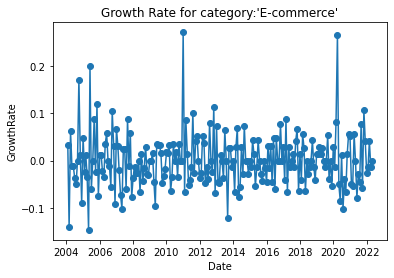

<Figure size 1600x500 with 0 Axes>

In [24]:
# Plot
plt.plot(category_ts['Growth_rate'], marker = 'o')

# Labelling 
plt.xlabel("Date")
plt.ylabel("GrowthRate")
plt.title("Growth Rate for category:'E-commerce'")
plt.figure(figsize = (16,5), dpi = 100)

# Display
plt.show()

**Category time series stationarity testing**

In [25]:
kpss_test(category_ts['Growth_rate'])

'Series is stationary'

In [26]:
adf_test(category_ts['Growth_rate'])

'Series is stationary'

### Wrangling manually extracted Keywords in EcommerceKeywordTimeSeries.csv

In [69]:
ecommerce_keyword_ts = pd.read_csv('EEcommerceKeywordTimeSeries.csv')
ecommerce_keyword_ts.rename(columns = {'date':'Date'}, inplace = True)
ecommerce_keyword_ts = ecommerce_keyword_ts.set_index(['Date'])
ecommerce_keyword_ts.index = pd.to_datetime(ecommerce_keyword_ts.index)
ecommerce_keyword_ts = ecommerce_keyword_ts.dropna()

In [70]:
ecommerce_keyword_ts.head(2)

,Uber,DoorDash,SkipTheDishes,Walmart,Costco,Real Canadian Superstore,alibaba,newegg canada,ebay,kijiji,...,Sportchek,square online,PayPal,Western Union,TD Canada Trust,Scotiabank,Royal Bank of Canada,Google Pay,Apple Pay,Mastercard
Date,,,,,,,,,,,,,,,,,,,,,
2004-01-01,0,0,0,0,0,0,0,0,60,0,...,0,0,54,40,0,0,80,0,0,0
2004-02-01,0,0,0,0,0,0,0,0,12,0,...,0,0,48,44,46,0,0,0,0,0


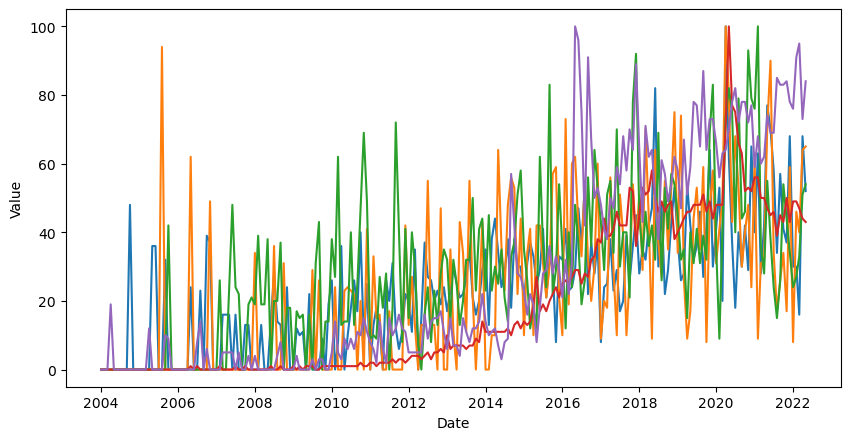

In [71]:
plot_df(ecommerce_keyword_ts[ecommerce_keyword_ts.columns[10:15]], width = 10)

###  Trend removal

#### Extracting and removing trend

In [72]:
def get_long_term_trend(dataframe, freq='M'):
    """extract the monthly trend from the series"""
    dataframe = np.log(dataframe)
    long_term_trend_data = dataframe.copy()
    if freq == 'Q':
        lamb = 1600
    elif freq == 'M':
        lamb = 1600*3**4
    for column_name in dataframe.columns:
        cycle, trend = sm.tsa.filters.hpfilter(dataframe[column_name], lamb)
        long_term_trend_data[column_name] = trend
    return long_term_trend_data


def remove_downward_trend_bias(dataframe, gdp_categoryts_df, freq = 'M'):
    """pass dataframe to remove bias and downward trend"""
    trend_data = get_long_term_trend(gdp_categoryts_df, freq)
    log_category = np.log(dataframe)
    log_category.replace([np.inf, -np.inf], 0, inplace=True)
    avg_logcategory = log_category.mean()
    pca = PCA(n_components=1)
    pca.fit(trend_data)
    component = pd.DataFrame(pca.fit_transform(trend_data))

    # rescale component
    # transformation source link: https://stats.stackexchange.com/questions/46429/transform-data-to-desired-mean-and-standard-deviation
    rescaled_component = avg_logcategory.mean() + (component - component.mean())*(avg_logcategory.std()/component.std())
    
    # remove long term bias
    transformed_data = log_category - rescaled_component.values
    transformed_data.index = pd.to_datetime(transformed_data.index)

    return transformed_data

In [73]:
def make_predictors_df(*arg):
    """joins the predictors dataframes"""
    if len(arg) > 1:
        for i in range(0, len(arg)-1):
            if i == 0:
                arg[i].index = pd.to_datetime(arg[i].index)
                arg[i+1].index = pd.to_datetime(arg[i+1].index)
                predictors_df = pd.merge(arg[i], arg[i+1], left_index=True, right_index=True)
            else:
                predictors_df = pd.merge(predictors_df, arg[i+1], left_index=True, right_index=True)
    else:
        arg[0].index = pd.to_datetime(arg[0].index)
        return arg[0]
    return predictors_df

### Normalize data

In [74]:
def normalize(dataframe):
    """function to normalize dataframe"""
    data = dataframe.copy()
    scaler = StandardScaler()
    scaler.fit(dataframe)
    scaled_df = pd.DataFrame(scaler.transform(dataframe))
    scaled_df.index = data.index
    scaled_df.columns = data.columns
    return scaled_df

# difference
def detrend(dataframe):
    """function to detrend time series"""
    return dataframe.diff().dropna()

# seasonality
def remove_seasonality(dataframe):
    """function for differencing of time series"""
    data = dataframe.copy()
    # monthly mean
    mean_data = dataframe.groupby(dataframe.index.month).mean()
    
    for i, d in enumerate(data.index):
        data.iloc[i,:] = mean_data.loc[d.month]
    removed_seaonality_data = dataframe - data
    return removed_seaonality_data

# cyclicity 
def remove_volatility(dataframe):
    """function for removing volatility of time series"""
    data = dataframe.copy()
    # monthly mean
    std_data = dataframe.groupby(dataframe.index.year).std()
    for i, d in enumerate(data.index):
        data.iloc[i,:] = std_data.loc[d.year]
    removed_vol_data = dataframe - data
    return removed_vol_data

In [75]:
normalized_ecommerce_keyword = normalize(ecommerce_keyword_ts)
detrend_ecommerce_keyword = (detrend(normalized_ecommerce_keyword))
check_stationarity(detrend_ecommerce_keyword)

Series DoorDash is trend stationary, trend needs to be removed
All other series are stationary


In [76]:
predictor = make_predictors_df(detrend_ecommerce_keyword)
response = make_predictors_df(retailEcommercesales_ts[['Growth_rate']])

In [77]:
detrend_ecommerce_keyword.head(3)

,Uber,DoorDash,SkipTheDishes,Walmart,Costco,Real Canadian Superstore,alibaba,newegg canada,ebay,kijiji,...,Sportchek,square online,PayPal,Western Union,TD Canada Trust,Scotiabank,Royal Bank of Canada,Google Pay,Apple Pay,Mastercard
Date,,,,,,,,,,,,,,,,,,,,,
2004-02-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-3.215939,0.0,...,0.0,0.0,-0.447656,0.256084,2.493022,0.0,-4.507752,0.0,0.0,0.000000
2004-03-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.205977,0.0,...,0.0,0.0,-0.373047,-1.344440,0.541961,0.0,5.634690,0.0,0.0,5.857352
2004-04-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.401992,0.0,...,0.0,0.0,0.000000,1.472482,-1.842668,0.0,-5.634690,0.0,0.0,-3.514411


### Split dataset into train, validation, test dataset

In [78]:
def ts_train_test_split(response, predictor, test_size):
    " splits the train and test set and also returns the extra test data of predictors"
    # train test split
    joind_df = pd.merge(response, predictor, left_index=True, right_index=True)
    train, test = train_test_split(joind_df, test_size=test_size, shuffle=False)
    # extra test data
    extra_test_data = predictor.loc[predictor.index > joind_df.index[len(joind_df.index)-1], :]
    return train, test, extra_test_data

In [79]:
train_df, test_df, extra_df = ts_train_test_split(retailEcommercesales_ts[['Growth_rate']],detrend_ecommerce_keyword, 0.2)

In [37]:
def lag_plots(data):
    """plots acf and pacf plots"""
    plot_acf(data)
    plot_pacf(data)

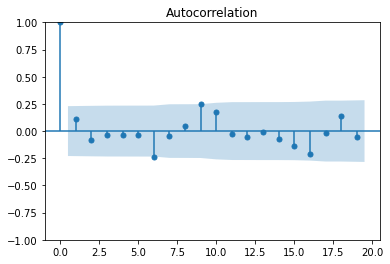

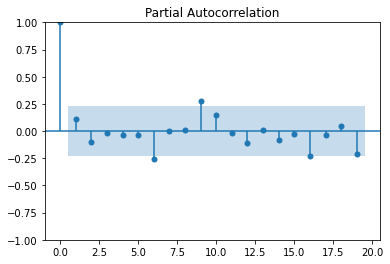

In [80]:
lag_plots(retailEcommercesales_ts[['Growth_rate']])

**Components of time series**

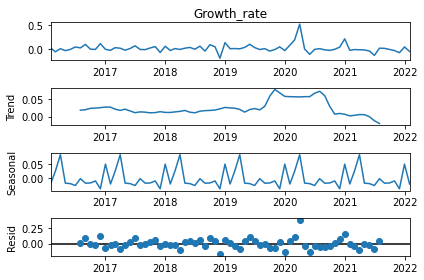

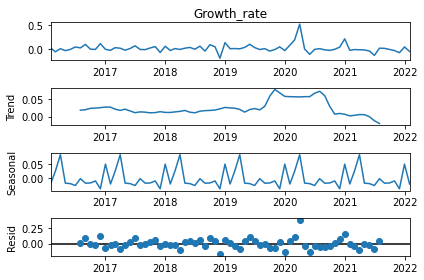

In [40]:
result=seasonal_decompose(retailEcommercesales_ts['Growth_rate'],  model='additive')
result.plot()

### Random Forest Model

In [117]:
def get_lag1_data(retailEcommercesales_ts, ecommerce_keyword_ts, response_var='Growth_rate'):
    """ passed response dataframe and predictors' dataframe"""
    lasso_key = detrend(normalize(ecommerce_keyword_ts))
    
    # response
    lasso_response_var = retailEcommercesales_ts[[response_var]].iloc[1:,:]

    # extract lag1 data to add to predictors
    lag1 = retailEcommercesales_ts[[response_var]].iloc[0:retailEcommercesales_ts.shape[0]-1,:]
    lag1.index = lasso_response_var.index
    lag1 = lag1.rename(columns={response_var: 'lag1'})
    lasso_predictors = make_predictors_df(lag1, lasso_key)
    
    # extra test data
    predictors_with_extra = make_predictors_df(lasso_key)
    extra_test_data = predictors_with_extra.loc[predictors_with_extra.index > lasso_predictors.index[len(lasso_predictors.index)-1], :]
    extra_test_data['lag1'] = lasso_response_var.iloc[-1][0]
    lasso_predictors = pd.concat([lasso_predictors, extra_test_data])
    return lasso_predictors, lasso_response_var

def randomForest_modelfit(train_rf, dependent_var='Growth_rate',n_trees=100):
    """ fits Random Forest model to the passed data"""
    x_train, y_train = train_rf.loc[:, ~train_rf.columns.isin([dependent_var])], train_rf[[dependent_var]]
    RFmodel = RandomForestRegressor(n_estimators=n_trees)
    RFmodel.fit(x_train, y_train)
    return RFmodel

# def rolling_prediction_RF(train, test, dependent_var='Growth_rate',n_trees=100):
#     """ Rolling prediction for test set"""
#     train_samples = train.shape[0]
#     test_samples = test.shape[0]
#     pred_data = pd.DataFrame(columns=None)
#     test_data = test.copy()
#     for i in range(train_samples+1, train_samples+test_samples+1):
#         modelfit = randomForest_modelfit(train, dependent_var,n_trees=100)

#         # Get first row of test set and make prediction
#         firstrow_test = np.transpose(pd.DataFrame((test.iloc[0, :])))
#         predicted_val = modelfit.predict(firstrow_test.loc[:, ~firstrow_test.columns.isin([dependent_var])])
#         predicted_val = pd.DataFrame(predicted_val)
#         pred_data = pred_data.append(predicted_val)

#         # update training set with one row
#         train = pd.concat([train, firstrow_test])

#         # Drop first row from test set now
#         test = test.drop(f"{firstrow_test.index[0]}")

#     pred_data.index = test_data.index
#     return pred_data

def rolling_prediction_randomForest(train, test,extra_test, dependent_var='Growth_rate',n_trees=100):
    """ Rolling prediction for xgboost"""
    train_copy = train.copy()
    test_copy = test.copy()
    train_samples = train.shape[0]
    test_samples = test.shape[0]
    pred_data = pd.DataFrame(columns=None)

    # rolling prediction for testing set
    if not test.empty:
        for i in range(train_samples+1, train_samples+test_samples+1):
            modelfit = randomForest_modelfit(train, dependent_var, n_trees=n_trees)

            # Get first row of test set and make prediction
            firstrow_test = np.transpose(pd.DataFrame((test.iloc[0, :])))
            predicted_val = modelfit.predict(firstrow_test.loc[:, ~firstrow_test.columns.isin([dependent_var])])
            predicted_val = pd.DataFrame(predicted_val)
            pred_data = pred_data.append(predicted_val)

            # update training set with one row
            train = pd.concat([train, firstrow_test])

            # Drop first row from test set now
            test = test.drop(f"{firstrow_test.index[0]}")

        pred_data.index = test_copy.index

    # rolling prediction for extra test set
    if not extra_test.empty:
        for i in range(0, extra_test.shape[0]):
            modelfit = randomForest_modelfit(train, dependent_var, n_trees=n_trees)

            # Get first row of extra test set and make prediction
            firstrow_test = np.transpose(pd.DataFrame((extra_test.iloc[0, :])))
            firstrow_test['lag1'] = firstrow_test.tail(1)['lag1'][0]
            predicted_val = modelfit.predict(firstrow_test.loc[:, ~firstrow_test.columns.isin([dependent_var])])
            firstrow_test['Growth_rate'] = predicted_val[0]
            predicted_val = pd.DataFrame(predicted_val)
            pred_data = pred_data.append(predicted_val)
            pred_data.rename(index={0:extra_test.index[0]}, inplace=True)

            # update training set with one row
            train = pd.concat([train, firstrow_test])

            # Drop first row from test set now
            extra_test = extra_test.drop(f"{firstrow_test.index[0]}")

    return pred_data



# RF Feature Importance Plot
def plot_feature_importance(importance, names, model_type, most_important_predictors=20):

    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df=fi_df.sort_values(by=['feature_importance'], ascending=False)
    fi_df=fi_df[0:most_important_predictors]

    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Seaborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])

    #Add chart labels
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')
    

**Model fitting Random Forest**

In [82]:
# get data for random forest
rf_predictors, rf_response = get_lag1_data(retailEcommercesales_ts, detrend_ecommerce_keyword, response_var='Growth_rate')

print(rf_predictors.shape)
print(rf_response.shape)

(75, 31)
(72, 1)


In [83]:
def ts_train_test_split(response, predictor, test_size):
    " splits the train and test set and also returns the extra test data of predictors"
    # train test split
    joind_df = pd.merge(response, predictor, left_index=True, right_index=True)
    train, test = train_test_split(joind_df, test_size=test_size, shuffle=False)
    # extra test data
    extra_test_data = predictor.loc[predictor.index > joind_df.index[len(joind_df.index)-1], :]
    return train, test, extra_test_data

In [176]:
# train test split
train_rf, test_rf, extra_rf = ts_train_test_split(rf_response, rf_predictors, test_size=0.2)
train_rf.shape

(57, 32)

In [177]:
# fit model
rfmodel = randomForest_modelfit(train_rf, dependent_var='Growth_rate',n_trees=600)

# fitted growth rate
X_rf, y_rf = train_rf.loc[:, ~train_rf.columns.isin(['Growth_rate'])], train_rf[['Growth_rate']]
fitted_growthRate_rf = rfmodel.predict(X_rf)
fitted_growthRate_rf = pd.DataFrame(fitted_growthRate_rf, columns={'Fitted EcommerceSales_GrowthRate'})
fitted_growthRate_rf.index = train_rf.index

In [178]:
# Rolling prediction of growth rate

pred_growthrate_rf = rolling_prediction_randomForest(train_rf, test_rf,extra_rf, dependent_var='Growth_rate',n_trees=600)

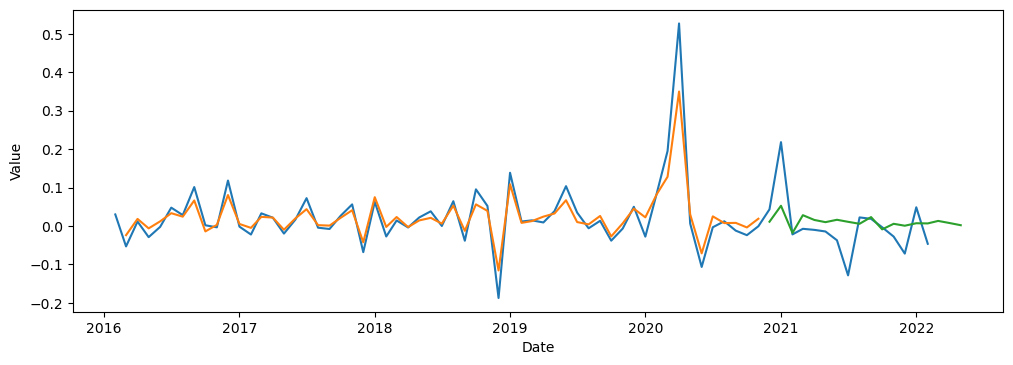

In [121]:
#fitted Ecommerce Sales

fitted_values_rf = pd.DataFrame({'EcommerceSales_GrowthRate': retailEcommercesales_ts['Growth_rate'],
                                'Fitted Value': fitted_growthRate_rf.squeeze(),
                                'Predicted Value': pred_growthrate_rf.squeeze()})
plot_df(fitted_values_rf, width=12, height=4)

In [133]:
def fitted_and_predicted_sales_randomForest(modelfit, pred_EcommerceGrowth, retailEcommercesales, train, test, extra_test):
    base_sales = retailEcommercesales['Ecommerce_sales'][1]
    
    # calculate fitted retail sales
    X_xgboost = train.loc[:, ~train.columns.isin(['Growth_rate'])]
    fitted_values = modelfit.predict(X_xgboost)  # fitted growth rate
    fitted_values = pd.DataFrame(fitted_values, columns={'Fitted GrowthRate'})
    fitted_values.index = train.index
    
    fitted_sales = [0]*(len(fitted_values)+1)
    fitted_sales[0] = base_sales
    for i, value in enumerate(fitted_values['Fitted GrowthRate']):
        fitted_sales[i+1] = fitted_sales[i]*(1 + value)
    fitted_sales_df = pd.DataFrame(fitted_sales[1:])
    fitted_sales_df.index = train.index

    #Test
    base_sales_test = retailEcommercesales[retailEcommercesales.index == train.index[-1]]['Ecommerce_sales'][0]
    predicted_sales = [0]*pred_EcommerceGrowth.shape[0]
    actual_sales = base_sales_test
    if not test.empty:
        for i in range(0, test.shape[0]):
            value = pred_EcommerceGrowth[0][i]
            predicted_sales[i] = actual_sales*(1 + value)
            actual_sales = retailEcommercesales.loc[test.index[i]][0]
        predicted_sales_df = pd.DataFrame(predicted_sales)
        predicted_sales_df.index = pred_EcommerceGrowth.index
        predicted_sales_df = pd.concat([retailEcommercesales[retailEcommercesales.index == train.index[-1]]['Ecommerce_sales'], predicted_sales_df])

        # prediction error calculation
        org = retailEcommercesales[retailEcommercesales.index >= pred_EcommerceGrowth.index[0]]
        error = 0
        for i in range(0, test.shape[0]):
            error = error + (org['Ecommerce_sales'][i]-predicted_sales_df[0][i])**2
        pred_error = np.sqrt(error/predicted_sales_df.shape[0])
        print(f"Prediction error: {pred_error}")

    # predicted sales trade value for extra test set when test set is not empty
    if not extra_test.empty and not test.empty:
        base_sales_test = retailEcommercesales[retailEcommercesales.index == test.index[-1]]['Ecommerce_sales'][0]
        actual_sales = base_sales_test
        for i in range(0, extra_test.shape[0]):
            value = pred_EcommerceGrowth.iloc[test.shape[0]+i][0]
            predicted_sales[i] = actual_sales*(1 + value)
            actual_sales = predicted_sales[i]
            predicted_sales_df.iloc[test.shape[0]+i+1][0] = predicted_sales[i]

    # predicted sales trade value for extra test set when test set is empty
    if not extra_test.empty and test.empty:
        base_sales_test = retailEcommercesales[retailEcommercesales.index == train.index[-1]]['Ecommerce_sales'][0]
        actual_sales = base_sales_test
        for i in range(0, extra_test.shape[0]):
            value = pred_EcommerceGrowth.iloc[i][0]
            predicted_sales[i] = actual_sales*(1 + value)
            actual_sales = predicted_sales[i]
        predicted_sales_df = pd.DataFrame(predicted_sales)
        predicted_sales_df.index = pred_EcommerceGrowth.index
        predicted_sales_df = pd.concat([retailEcommercesales[retailEcommercesales.index == train.index[-1]]['Ecommerce_sales'], predicted_sales_df])
        pred_error = None


    # Plot actual and fitted retail trade
    Actual_sales = retailEcommercesales['Ecommerce_sales'][1:]
    fittedandActual_sales = pd.DataFrame({'Actual Retail': Actual_sales,
                                        'Fitted Retail': fitted_sales_df.squeeze(),
                                        'Predicted Retail': predicted_sales_df.squeeze()
                                       })
    fig = plot_df
    (fittedandActual_sales, width=10, height=3)
    return pred_error, fig, fittedandActual_sales

In [128]:
retailEcommercesales.loc[test_rf.index[1]][0]

4384087

Prediction error: 336542.7962878599


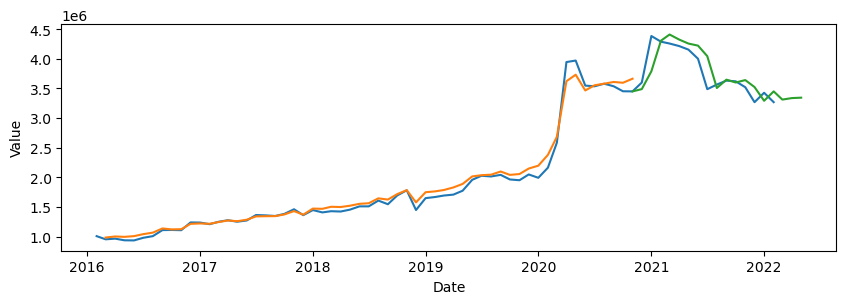

In [135]:
#n_trees=600
prediction_error, figure, actual_fitted_sales = fitted_and_predicted_sales_randomForest(rfmodel, pred_growthrate_rf, retailEcommercesales, train_rf, test_rf, extra_rf)

#### Bootstrap

In [106]:
from arch.bootstrap import optimal_block_length, CircularBlockBootstrap
from numpy.random import RandomState

In [110]:
def get_bootstrap_samples(train_data, n_sample=100, rs=None):
    """ get circular and overlapping bootstrap samples """

    #block_size = int(optimal_block_length(train_data).mean()[1])
    #print("Block size: ", block_size)
    bs = CircularBlockBootstrap(10, train_data, random_state=rs)
    bs_data_lst = list()

    # create list of bootstrap samples
    for data in bs.bootstrap(n_sample):
        data[0][0].index = train_data.index
        bs_data_lst.append(data[0][0])
    return bs_data_lst


In [154]:
# function to plot prediction band for growth rate and also returns prediction band data
def growth_rate_plot_and_data_bs(predicted_growth_df=None,
                              lower_q = 0.025,
                              upper_q = 0.975,
                              modelfit= None, 
                              gdpts = None, 
                              train = None,
                              pred_gdpGrowth = None,fitted_growthrate=None):

    pred_growth_rate_data = pd.DataFrame(columns=['Predicted E-commerce Growth Rate',
                                                  'Prediction interval (2.5%)',
                                                  'Prediction interval (97.5%)',
                                                  'Mean (Prediction interval)'])
    # calcualte quantiles
    quantiles = predicted_growth_df.quantile(q=[0.025, 0.975], axis=1, interpolation='linear')
    growth_quantiles = np.transpose(quantiles)

    pred_growth_rate_data['Predicted E-commerce Growth Rate'] = pred_gdpGrowth
    pred_growth_rate_data['Prediction interval (2.5%)'] = growth_quantiles[lower_q]
    pred_growth_rate_data['Prediction interval (97.5%)'] = growth_quantiles[upper_q]
    pred_growth_rate_data['Mean (Prediction interval)'] = predicted_growth_df.mean(axis=1)

    # organise data for plot
    pred_gdpGrowth_for_plot = pd.concat([train['Growth_rate'].tail(1), pred_gdpGrowth])
    fitted_values = pd.DataFrame({'Ecommerce_GrowthRate': retailEcommercesales_ts['Growth_rate'],
                                  'Fitted Value': fitted_growthrate.squeeze(),
                                  'Predicted Value': pred_gdpGrowth_for_plot.squeeze()})

    # plot
    fitted_values.index = pd.to_datetime(fitted_values.index)
    fig = plt.figure(figsize=(12, 4), dpi=100)
    plt.plot(fitted_values, marker='o', markersize=4)
    plt.plot(predicted_growth_df.mean(axis=1), color='green', linestyle='--')
    plt.fill_between(growth_quantiles.index, growth_quantiles[lower_q], growth_quantiles[upper_q], alpha = 0.2, color = 'green')
    plt.gca().set(title="", xlabel="", ylabel="")
    plt.close()
    return fig, pred_growth_rate_data

In [137]:
# create bootstrap samples
bs_samples = get_bootstrap_samples(train_rf, n_sample=10, rs=RandomState(1234))

# get predicted growth rate uisng bootstrap samples
predicted_growth_df = pd.DataFrame(columns=list(range(0, len(bs_samples))))
for i, df in enumerate(bs_samples):
    predicted_growth_temp = rolling_prediction_randomForest(df, test_rf, extra_rf, dependent_var='Growth_rate',n_trees=100)
    predicted_growth_df.iloc[:, i] = predicted_growth_temp[0]

In [138]:
predicted_growth_df

,0,1,2,3,4,5,6,7,8,9
2020-12-01,0.014042,0.000040,0.035211,-0.065239,0.015731,0.014551,0.007489,-0.005160,0.009444,-0.035629
2021-01-01,0.057503,0.022517,0.045309,0.067058,0.164357,0.054554,0.051047,0.073287,0.038570,0.005962
2021-02-01,0.059226,0.094485,-0.065480,0.035122,0.075445,0.002745,0.102104,0.082375,0.047415,-0.088852
2021-03-01,0.017886,0.001277,0.009219,-0.015259,0.035251,0.069654,0.046144,0.065095,0.041917,-0.014402
2021-04-01,0.022101,0.020758,0.013799,0.005157,0.012601,0.020513,0.016594,0.014778,0.029982,0.017300
2021-05-01,0.028671,0.031688,0.025068,0.009909,0.015987,0.026119,0.026384,0.030407,0.026999,-0.000976
2021-06-01,0.010281,0.016736,0.052725,0.011674,0.004976,0.049848,0.042958,0.008438,0.023112,0.024880
2021-07-01,0.008595,0.023916,0.019676,0.007501,0.005710,0.003822,-0.005392,-0.006882,-0.001219,0.012454
2021-08-01,0.009138,0.014587,-0.006131,-0.032494,-0.004994,0.031828,0.024519,0.024030,0.009503,-0.013291
2021-09-01,0.027088,0.035660,0.022105,0.019954,0.020892,0.015172,0.037486,0.036800,0.029647,0.030772


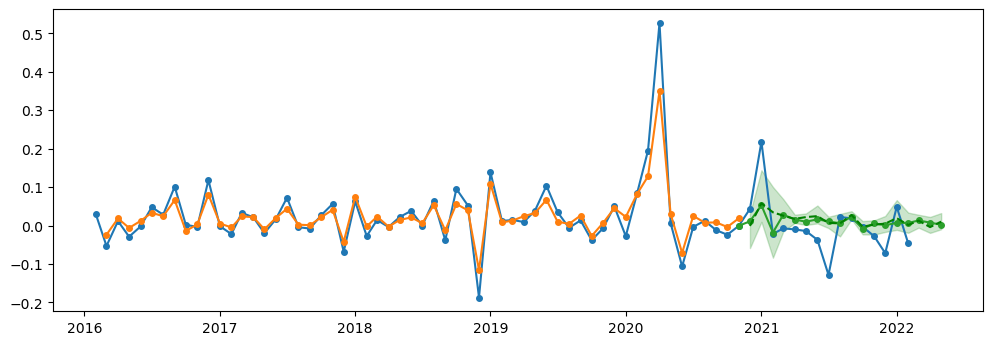

In [156]:
fig, pred_growth_rate_data = growth_rate_plot_and_data_bs(predicted_growth_df=predicted_growth_df,
                              lower_q = 0.025,
                              upper_q = 0.975,
                              modelfit= rfmodel, 
                              gdpts = retailEcommercesales_ts, 
                              train = train_rf,
                              pred_gdpGrowth = pred_growthrate_rf,fitted_growthrate=fitted_growthRate_rf)

fig

In [157]:
pred_growth_rate_data.tail()

,Predicted E-commerce Growth Rate,Prediction interval (2.5%),Prediction interval (97.5%),Mean (Prediction interval)
2022-01-01,0.007198,-0.011225,0.066196,0.019336
2022-02-01,0.006740,-0.018797,0.033723,0.001495
2022-03-01,0.013240,-0.005465,0.028090,0.012828
2022-04-01,0.007724,-0.019074,0.022419,-0.003995
2022-05-01,0.002049,-0.009551,0.032510,0.010233


In [164]:
# get predicted gdp value for bootstrap samples

predicted_e_df_bs = pd.DataFrame(columns=list(range(0, len(bs_samples))))
for i, df in enumerate(bs_samples):
    predicted_growth_rate_temp = predicted_growth_df[[i]].rename(columns={i: 0})
    _, _, e_data = fitted_and_predicted_sales_randomForest(rfmodel, predicted_growth_rate_temp, retailEcommercesales, train_rf, test_rf, extra_rf)
    predicted_e_df_bs.iloc[:, i] = e_data['Predicted Retail'].dropna()

Prediction error: 345852.0050675588
Prediction error: 380303.1456763606
Prediction error: 354885.7212569912
Prediction error: 375467.4905213042
Prediction error: 324893.7833252803
Prediction error: 367546.6744825405
Prediction error: 378694.4527490506
Prediction error: 354735.5352760863
Prediction error: 353593.0653864249
Prediction error: 385375.4313458414


In [160]:
e_data.head()

,Actual Retail,Fitted Retail,Predicted Retail
2016-02-01,1006610.0,NaN,NaN
2016-03-01,953186.0,9.826339e+05,NaN
2016-04-01,964279.0,1.000768e+06,NaN
2016-05-01,936366.0,9.946420e+05,NaN
2016-06-01,934274.0,1.006701e+06,NaN


In [171]:
def ecommerce_plot_and_data_bs(modelfit, pred_EcommerceGrowth, retailEcommercesales, train, test, extra_test, predicted_e_df_bs, lower_q = 0.025, upper_q = 0.975):
    # fitted gdp value for training set
    base_sales = retailEcommercesales['Ecommerce_sales'][1]
    
    # calculate fitted retail sales
    X_xgboost = train.loc[:, ~train.columns.isin(['Growth_rate'])]
    fitted_values = modelfit.predict(X_xgboost)  # fitted growth rate
    fitted_values = pd.DataFrame(fitted_values, columns={'Fitted GrowthRate'})
    fitted_values.index = train.index
    
    fitted_sales = [0]*(len(fitted_values)+1)
    fitted_sales[0] = base_sales
    for i, value in enumerate(fitted_values['Fitted GrowthRate']):
        fitted_sales[i+1] = fitted_sales[i]*(1 + value)
    fitted_sales_df = pd.DataFrame(fitted_sales[1:])
    fitted_sales_df.index = train.index

    #Test
    base_sales_test = retailEcommercesales[retailEcommercesales.index == train.index[-1]]['Ecommerce_sales'][0]
    predicted_sales = [0]*pred_EcommerceGrowth.shape[0]
    actual_sales = base_sales_test
    if not test.empty:
        for i in range(0, test.shape[0]):
            value = pred_EcommerceGrowth[0][i]
            predicted_sales[i] = actual_sales*(1 + value)
            actual_sales = retailEcommercesales.loc[test.index[i]][0]
        predicted_sales_df = pd.DataFrame(predicted_sales)
        predicted_sales_df.index = pred_EcommerceGrowth.index
        predicted_sales_df = pd.concat([retailEcommercesales[retailEcommercesales.index == train.index[-1]]['Ecommerce_sales'], predicted_sales_df])

        # prediction error calculation
        org = retailEcommercesales[retailEcommercesales.index >= pred_EcommerceGrowth.index[0]]
        error = 0
        for i in range(0, test.shape[0]):
            error = error + (org['Ecommerce_sales'][i]-predicted_sales_df[0][i])**2
        pred_error = np.sqrt(error/predicted_sales_df.shape[0])
        print(f"Prediction error: {pred_error}")

    # predicted sales trade value for extra test set when test set is not empty
    if not extra_test.empty and not test.empty:
        base_sales_test = retailEcommercesales[retailEcommercesales.index == test.index[-1]]['Ecommerce_sales'][0]
        actual_sales = base_sales_test
        for i in range(0, extra_test.shape[0]):
            value = pred_EcommerceGrowth.iloc[test.shape[0]+i][0]
            predicted_sales[i] = actual_sales*(1 + value)
            actual_sales = predicted_sales[i]
            predicted_sales_df.iloc[test.shape[0]+i+1][0] = predicted_sales[i]

    # predicted sales trade value for extra test set when test set is empty
    if not extra_test.empty and test.empty:
        base_sales_test = retailEcommercesales[retailEcommercesales.index == train.index[-1]]['Ecommerce_sales'][0]
        actual_sales = base_sales_test
        for i in range(0, extra_test.shape[0]):
            value = pred_EcommerceGrowth.iloc[i][0]
            predicted_sales[i] = actual_sales*(1 + value)
            actual_sales = predicted_sales[i]
        predicted_sales_df = pd.DataFrame(predicted_sales)
        predicted_sales_df.index = pred_EcommerceGrowth.index
        predicted_sales_df = pd.concat([retailEcommercesales[retailEcommercesales.index == train.index[-1]]['Ecommerce_sales'], predicted_sales_df])
        pred_error = None

    pred_e_data = pd.DataFrame(columns=['Predicted Ecommerce Value',
                                                  'Prediction interval (2.5%)',
                                                  'Prediction interval (97.5%)',
                                                  'Mean (Prediction interval)'])
    # calcualte quantiles
    quantiles = predicted_e_df_bs.quantile(q=[lower_q, upper_q], axis=1, interpolation='linear')
    value_quantiles = np.transpose(quantiles)

    pred_e_data['Predicted Ecommerce Value'] = predicted_sales_df[0][1:]
    pred_e_data['Prediction interval (2.5%)'] = value_quantiles[lower_q]
    pred_e_data['Prediction interval (97.5%)'] = value_quantiles[upper_q]
    pred_e_data['Mean (Prediction interval)'] = predicted_e_df_bs.mean(axis=1)

    Actual_Ecommerce = retailEcommercesales['Ecommerce_sales'][1:]
    fittedandActual_sales = pd.DataFrame({'Actual Ecommerce': Actual_Ecommerce,
                                        'Fitted Ecommerce': fitted_sales_df.squeeze(),
                                        'Predicted Ecommerce': predicted_sales_df.squeeze()
                                       })

    # plot
    fittedandActual_sales.index = pd.to_datetime(fittedandActual_sales.index)
    fig = plt.figure(figsize=(12, 4), dpi=100)
    plt.plot(fittedandActual_sales, marker='o', markersize=4)
    plt.plot(predicted_e_df_bs.mean(axis=1), color='green', linestyle='--')
    plt.fill_between(value_quantiles.index, value_quantiles[lower_q], value_quantiles[upper_q], alpha = 0.2, color = 'green')
    plt.gca().set(title="", xlabel="", ylabel="")
    plt.close()
    return fig, pred_e_data

Prediction error: 336542.7962878599


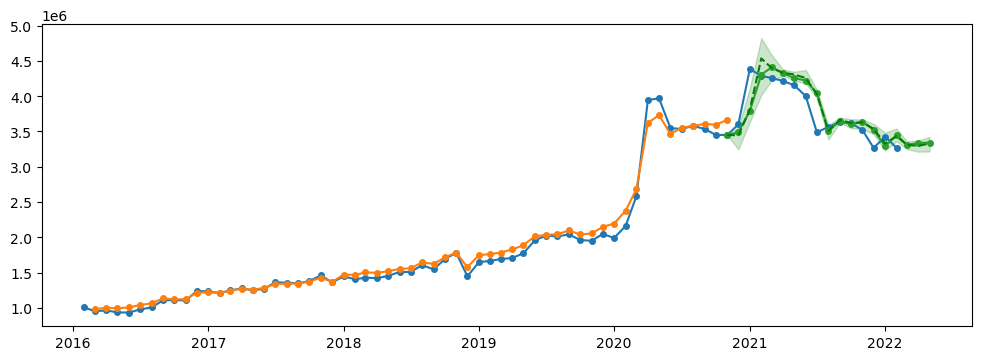

In [172]:
fig, pred_e_data = ecommerce_plot_and_data_bs(rfmodel, pred_growthrate_rf, retailEcommercesales, train_rf, test_rf, extra_rf, predicted_e_df_bs, 
                                          lower_q = 0.025, upper_q = 0.975)
fig